In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from duckreg.estimators import DuckMundlak, DuckDoubleDemeaning
import duckdb
import pyfixest as pf

np.random.seed(42)

In [2]:
def panel_dgp(
    num_units=1000,
    num_periods=30,
    num_treated=50,
    treatment_start=15,
    hetfx=False,
    base_treatment_effect=np.repeat(0, 15),
    ar_coef=0.2,  # Autoregressive coefficient for epsilon_it
    sigma_unit=1,
    sigma_time=0.5,
    sigma_epsilon = 0.5,  # Standard deviation of epsilon_it
):
    unit_intercepts = np.random.normal(0, sigma_unit, num_units)

    # Generate day-of-the-week pattern
    day_effects = np.array([-0.1, 0.1, 0, 0, 0.1, 0.5, 0.5])  # Stronger effects on weekends
    day_pattern = np.tile(day_effects, num_periods // 7 + 1)[:num_periods]

    # Generate autoregressive structure
    ar_coef_time = 0.2
    ar_noise_time = np.random.normal(0, sigma_time, num_periods)
    time_intercepts = np.zeros(num_periods)
    time_intercepts[0] = ar_noise_time[0]
    for t in range(1, num_periods):
        time_intercepts[t] = ar_coef_time * time_intercepts[t - 1] + ar_noise_time[t]
    # Combine day-of-the-week pattern and autoregressive structure
    time_intercepts = day_pattern + time_intercepts - np.mean(time_intercepts)
    # Generate autoregressive noise for each unit
    ar_noise = np.random.normal(0, sigma_epsilon, (num_units, num_periods))
    noise = np.zeros((num_units, num_periods))
    noise[:, 0] = ar_noise[:, 0]
    for t in range(1, num_periods):
        noise[:, t] = ar_coef * noise[:, t - 1] + ar_noise[:, t]
    # N X T matrix of potential outcomes under control
    Y0 = unit_intercepts[:, np.newaxis] + time_intercepts[np.newaxis, :] + noise
    # Generate the base treatment effect (concave structure)
    # Generate heterogeneous multipliers for each unit
    if hetfx:
        heterogeneous_multipliers = np.random.uniform(0.5, 1.5, num_units)
    else:
        heterogeneous_multipliers = np.ones(num_units)

    # Create a 2D array to store the heterogeneous treatment effects
    treatment_effect = np.zeros((num_units, num_periods - treatment_start))
    for i in range(num_units):
        treatment_effect[i, :] = heterogeneous_multipliers[i] * base_treatment_effect

    # random assignment
    treated_units = np.random.choice(num_units, num_treated, replace=False)
    treatment_status = np.zeros((num_units, num_periods), dtype=bool)
    treatment_status[treated_units, treatment_start:] = True

    # Apply the heterogeneous treatment effect to the treated units
    Y1 = Y0.copy()
    for t in range(treatment_start, num_periods):
        Y1[:, t][treatment_status[:, t]] += treatment_effect[:, t - treatment_start][
            treatment_status[:, t]
        ]

    # Create a DataFrame
    unit_ids = np.repeat(np.arange(num_units), num_periods)
    time_ids = np.tile(np.arange(num_periods), num_units)
    W_it = treatment_status.flatten()
    Y_it = np.where(W_it, Y1.flatten(), Y0.flatten())
    unit_intercepts_flat = np.repeat(unit_intercepts, num_periods)
    time_intercepts_flat = np.tile(time_intercepts, num_units)
    df = pd.DataFrame(
        {
            "unit_id": unit_ids,
            "time_id": time_ids,
            "W_it": W_it.astype(int),
            "Y_it": Y_it,
            "unit_intercept": unit_intercepts_flat,
            "time_intercept": time_intercepts_flat,
        }
    )
    # assign units to ever treated if the max of W_it is 1
    df["ever_treated"] = df.groupby("unit_id")["W_it"].transform("max")
    return df

# Function to create and populate DuckDB database
def create_duckdb_database(df, db_name="large_dataset.db", table="panel_data"):
    conn = duckdb.connect(db_name)
    conn.execute(f"DROP TABLE IF EXISTS {table}")
    conn.execute(f"CREATE TABLE {table} AS SELECT * FROM df")
    conn.close()
    print(f"Data loaded into DuckDB database: {db_name}")

In [3]:
num_periods = 30
treat_start_period = 15
treat_effect_vector= 0.2 * np.log(2 * np.arange(1, num_periods - treat_start_period + 1))
treat_effect_vector[8:] = 0 # switch off effects after a week
sigma_i, sigma_t = 2, 1
treat_effect_vector.mean()

np.float64(0.21533040462966416)

In [4]:
df = panel_dgp(
    num_units=100_000, num_treated= 50_000,
    num_periods=30,
    treatment_start = treat_start_period,
    hetfx=False,
    base_treatment_effect = treat_effect_vector,
    sigma_unit = sigma_i, sigma_time = sigma_t,
)

db_name = 'event_study_data.db'
create_duckdb_database(df, db_name)
df = df.merge(
    pd.get_dummies(df["time_id"], prefix="time"), left_index=True, right_index=True
)
time_dummies = df.filter(regex = r"time_\d").columns

Data loaded into DuckDB database: event_study_data.db


### in-memory estimation

Eq 5.13 in Wooldridge

$$
Y_{it} = \alpha + \xi d_i + \beta_q(d_i fq_t) + \dots + \beta_T(d_i fT_t) + \theta_0 fq_t + \theta_T fT_t + \epsilon_{it}
$$

where $\beta$ coefficients are the event study coefficients.

In [5]:
print(ff := f"""
        Y_it ~ ever_treated*({' + '.join(time_dummies)})
         """)
m = pf.feols(ff, data = df)


        Y_it ~ ever_treated*(time_0 + time_1 + time_2 + time_3 + time_4 + time_5 + time_6 + time_7 + time_8 + time_9 + time_10 + time_11 + time_12 + time_13 + time_14 + time_15 + time_16 + time_17 + time_18 + time_19 + time_20 + time_21 + time_22 + time_23 + time_24 + time_25 + time_26 + time_27 + time_28 + time_29)
         


/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:2324: UserWarning: 
            The following variables are collinear: ['time_29'].
            The variables are dropped from the model.
            
  warnings.warn(
/home/alal/Desktop/code/econometrics/pyfixest/pyfixest/estimation/feols_.py:727: RuntimeWarning: invalid value encountered in sqrt
  self._se = np.sqrt(np.diagonal(_vcov))


Event study regression

In [6]:
m2 = pf.feols("""
              Y_it ~ i(time_id, ever_treated,  ref = 14) |
                unit_id + time_id
              """,
              df
             )
evstudy_coefs = m2.coef().values
# insert zero in reference period
evstudy_coefs = np.insert(evstudy_coefs, 14, 0)

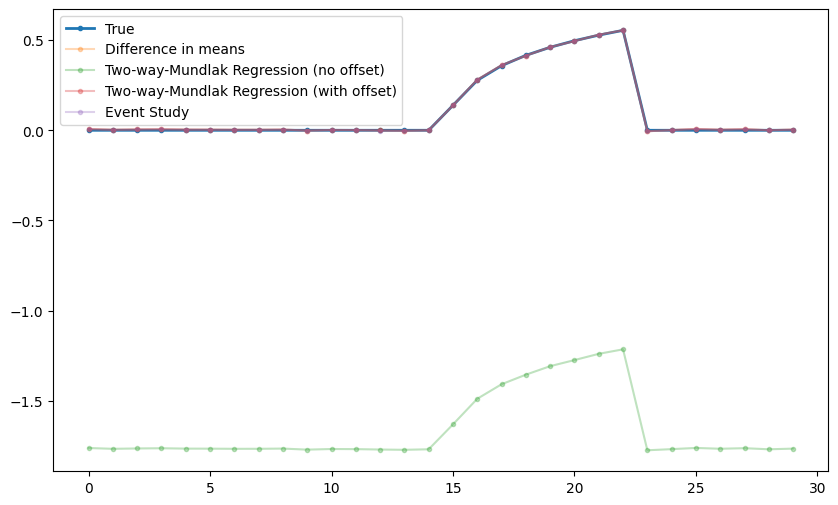

In [11]:
p0 = np.r_[np.zeros(15), treat_effect_vector]
p1 = m.coef().filter(regex=r"ever_treated:time_\d").values


p2 = (
    df.groupby(["ever_treated", "time_id"])["Y_it"]
    .mean()
    .unstack()
    .diff(axis=0)
    .iloc[1, :]
    .values
)
f, ax = plt.subplots(figsize = (10, 6))
ax.plot(p0, marker=".", label="True", linewidth=2)
ax.plot(p2, marker=".", alpha=0.3, label="Difference in means")
ax.plot(p1, marker=".", alpha=0.3, label="Two-way-Mundlak Regression (no offset)")
ax.plot(
    p1 + m.coef().filter(regex="ever_treated$").values,
    marker=".",
    alpha=0.3,
    label="Two-way-Mundlak Regression (with offset)",
)
ax.plot(evstudy_coefs, marker=".", alpha=0.3, label="Event Study")
ax.legend()

We get the same coefficient once we offset the $\beta$ vector with $\xi$. 

So, the gameplan is to groupby (cohort, time) and run the compressed regression by weighted least squares.

## Duckdb queries

In progress

In [5]:
twm = DuckMundlak(
  db_name = db_name,
  table_name = 'panel_data',
  outcome_var='Y_it',
  unit_col = 'unit_id',
  time_col = 'time_id',
  covariates=["W_it"],
  cluster_col="unit_id",
  n_bootstraps=50,
  seed=42,
  keep_connection_open=True,
)

twm.fit()

100%|██████████| 50/50 [00:05<00:00,  9.52it/s]


In [6]:
mundlak_results = twm.summary()
restab = pd.DataFrame(
  np.c_[mundlak_results['point_estimate'], mundlak_results['standard_error']],
  columns=['point_estimates', 'standard_error'],
)
restab.iloc[1,:]

point_estimates    0.213718
standard_error     0.000990
Name: 1, dtype: float64

### manual computation of event study quantities

In [7]:
twm.queries()

{'bootstrap_query': '\n            SELECT\n                W_it,\n                avg_W_it_unit\n                , avg_W_it_time,\n                COUNT(*) as count,\n                SUM(Y_it) as sum_Y_it\n            FROM design_matrix\n            WHERE unit_id IN (SELECT unnest((?)))\n            GROUP BY W_it,\n                        avg_W_it_unit\n                        , avg_W_it_time\n            ',
 'compress_query': '\n        SELECT\n            W_it,\n            avg_W_it_unit\n            , avg_W_it_time,\n            COUNT(*) as count,\n            SUM(Y_it) as sum_Y_it\n        FROM design_matrix\n        GROUP BY W_it,\n                    avg_W_it_unit\n                    , avg_W_it_time\n        ',
 'design_matrix_query': '\n        CREATE TEMP TABLE design_matrix AS\n        SELECT\n            t.unit_id,\n            t.time_id,\n            t.Y_it,\n            t.W_it,\n            u.avg_W_it_unit\n            , tm.avg_W_it_time\n        FROM panel_data t\n       

In [20]:
print(twm.queries['design_matrix_query'])
print(twm.queries['compress_query'])


        CREATE TEMP TABLE design_matrix AS
        SELECT
            t.unit_id,
            t.time_id,
            t.Y_it,
            t.W_it,
            u.avg_W_it_unit
            , tm.avg_W_it_time
        FROM panel_data t
        JOIN unit_avgs u ON t.unit_id = u.unit_id
        JOIN time_avgs tm ON t.time_id = tm.time_id
        

        SELECT
            W_it,
            avg_W_it_unit
            , avg_W_it_time,
            COUNT(*) as count,
            SUM(Y_it) as sum_Y_it
        FROM design_matrix
        GROUP BY W_it,
                    avg_W_it_unit
                    , avg_W_it_time
        


In [ ]:
qq = """
        CREATE TEMP TABLE unit_avgs AS
        SELECT unit_id,
               AVG(W_it) AS avg_W_it_unit
        FROM panel_data
        GROUP BY unit_id
"""

In [15]:
twm.df_compressed

,W_it,avg_W_it_unit,avg_W_it_time,count,sum_Y_it,mean_Y_it
0,0,0.0,0.0,750000,-137074.952220,-0.182767
1,1,0.5,0.5,750000,529538.118975,0.706051
2,0,0.0,0.5,750000,350996.605720,0.467995
3,0,0.5,0.0,750000,-118822.210458,-0.158430


In [12]:
print(twm.queries['unit_avg_query'])


        CREATE TEMP TABLE unit_avgs AS
        SELECT unit_id,
               AVG(W_it) AS avg_W_it_unit
        FROM panel_data
        GROUP BY unit_id
        
